In [64]:
import numpy as np
import jax
from jax import numpy as jnp

import distrax
import haiku as hk

#from ima.upsampling import Pad

import optax

from tqdm import tqdm
from matplotlib import pyplot as plt

In [65]:
#from ima.upsampling import Pad

class Pad(distrax.Bijector):
    def __init__(self, pad):
        if isinstance(pad[0], int):
            pad = (pad,)
        super().__init__(len(pad))
        self.pad = pad

    def forward_and_log_det(self, x):
        pad = (len(x.shape) - len(self.pad)) * ((0, 0),) + self.pad
        y = jnp.pad(x, pad)
        return y, jnp.zeros(x.shape[0])

    def inverse_and_log_det(self, y):
        slices = (len(y.shape) - len(self.pad)) * [slice(0, None)]
        for p in self.pad:
            e = None if p[1] == 0 else -p[1]
            slices.append(slice(p[0], e))
        return y[tuple(slices)], jnp.zeros(y.shape[0])


In [66]:
key = jax.random.PRNGKey(1)

In [67]:
# Generate training data

d = 10
D = 1000
N = 10000

key, subkey = jax.random.split(key)
sources = jax.random.normal(subkey, shape=(N, d))

key, subkey = jax.random.split(key)
A = jax.random.normal(subkey, shape=(D, d)) / np.sqrt(d)

key, subkey = jax.random.split(key)
mv = lambda m, v: jnp.matmul(m, v)
mbv = jax.vmap(mv, (None, 0), 0)
observations = mbv(A, sources) + 0.2 * jax.random.normal(subkey, shape=(N, D))

In [68]:
observations.shape

(10000, 1000)

In [69]:
sources.shape

(10000, 10)

In [70]:
# Define Real NVP flow with Distrax
def mk_flow(K = 16, nl = 2, hu = 256):
    pad = Pad((0, D - d))
    layers = []
    for i in range(K):
        mlp = hk.Sequential([hk.nets.MLP(nl * (hu,), activate_final=True),
                             hk.Linear(D, w_init=jnp.zeros, b_init=jnp.zeros)])
        def bij_fn(params):
            bij = distrax.ScalarAffine(shift=params[..., :D // 2], log_scale=params[..., D // 2:])
            return distrax.Block(bij, 1)
        layers.append(distrax.SplitCoupling(D // 2, 1, mlp, bij_fn, swap=bool(i % 2)))
    flow = distrax.Chain(layers)
    return (pad, flow)

def fwd_(x):
    pad, flow = mk_flow()
    
    x = pad.forward(x)
    return flow.forward(x)

def inv_(x):
    pad, flow = mk_flow()
    
    x = flow.inverse(x)
    return pad.inverse(x)

In [71]:
key, subkey = jax.random.split(key)
fwd = hk.transform(fwd_)
inv = hk.transform(inv_)
params = fwd.init(subkey, jnp.array(np.random.randn(5, d)))

In [72]:
# Loss function

def loss_(args):
    x, lam, beta = args
    pad, flow = mk_flow()
    
    fwd = lambda y: flow.forward(pad.forward(y))
    inv = lambda y: pad.inverse(flow.inverse(y))
    
    base_dist = distrax.Independent(distrax.Normal(loc=jnp.zeros(d), scale=jnp.ones(d)),
                                    reinterpreted_batch_ndims=1)
    
    jac_fn = jax.vmap(jax.jacfwd(fwd))
    
    z = inv(x)
    jac = jac_fn(z)
    
    jj = jax.lax.batch_matmul(jnp.transpose(jac, (0, 2, 1)), jac)
    chol = jax.vmap(jax.scipy.linalg.cholesky)(jj)
    log_det = jnp.sum(jnp.log(jax.vmap(jnp.diag)(chol)), -1)
    
    diff = jnp.mean((x - fwd(z)) ** 2)
    
    return jnp.mean(-lam * (base_dist.log_prob(z) - log_det) + beta * diff)

In [73]:
key, subkey = jax.random.split(key)
loss = hk.transform(loss_)
params = loss.init(subkey, (jnp.array(np.random.randn(5, D)), 1., 1.))

In [74]:
b = jnp.array(np.random.randn(5, D))

In [75]:
loss.apply(params, None, (b, 1., 1.))

DeviceArray(14.00994, dtype=float32)

In [76]:
# Define the optimizer
optimizer = optax.adam(0.001)

# Initialize the optimizer state  
opt_state = optimizer.init(params)

@jax.jit
def step(opt_state_, x_, lam_, beta_):
    params_ = params  # Directly access params as they are not a part of opt_state in Optax
    value, grads = jax.value_and_grad(loss.apply)(params_, None, (x_, lam_, beta_))
    updates, opt_state_ = optimizer.update(grads, opt_state_)
    params_ = optax.apply_updates(params_, updates)  # Update params
    return value, opt_state_



In [77]:
num_iter = 1000
lam_int = [40, 2000]
batch_size = 256
beta = 20.

loss_hist = np.zeros((0, 2))

In [78]:

for it in tqdm(range(num_iter)):
    x = observations[np.random.choice(N, batch_size)]
    
    # Need to warm up lambda due to stability issues
    lam = np.interp(it, lam_int, [0, 1])  
    
    loss_val, opt_state = step(opt_state, x, lam, beta)
    
    loss_append = np.array([[it + 1, loss_val.item()]])
    loss_hist = np.concatenate([loss_hist, loss_append])


100%|██████████| 1000/1000 [12:25<00:00,  1.34it/s]


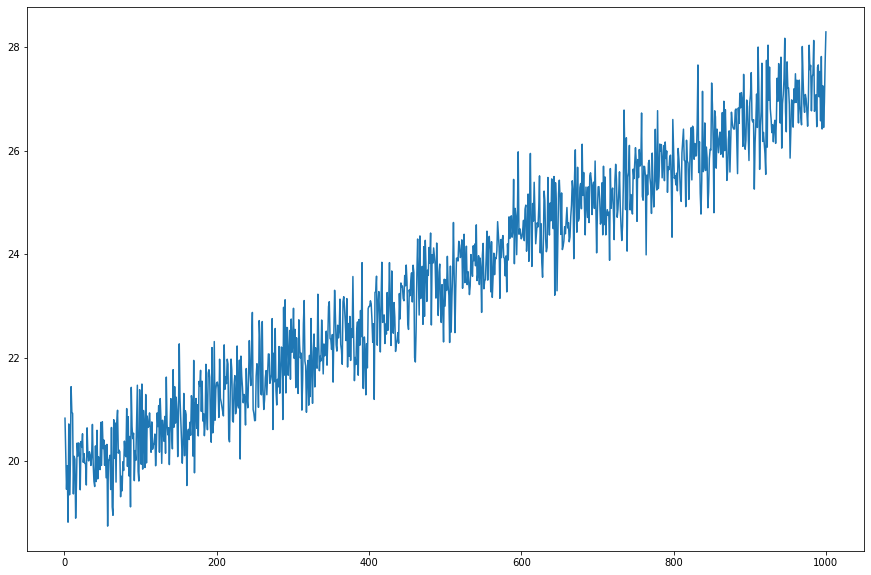

In [80]:
plt.figure(figsize=(15, 10))
plt.plot(loss_hist[:, 0], loss_hist[:, 1])
plt.show()

In [83]:
loss_hist

array([[   1.        ,   20.83104324],
       [   2.        ,   20.10561752],
       [   3.        ,   19.45594597],
       ...,
       [ 998.        ,   26.93434334],
       [ 999.        ,   27.71444702],
       [1000.        ,   28.29756355]])

In [89]:
loss_hist[0,1]

20.831043243408203

In [87]:
loss_hist.shape

(1000, 2)

In [90]:
loss_hist[999,1]

28.297563552856445